# 9.4 Phantom simulation

In this simulation we go directly from the patient coordinates to the MRI coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import nibabel as nib
import math
from statistics import mean 
from sksurgeryvtk.models.vtk_surface_model import VTKSurfaceModel
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sksurgeryvtk.models.vtk_surface_model import VTKSurfaceModel



ModuleNotFoundError: No module named 'sksurgeryvtk'

In [2]:
%matplotlib inline

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

added /Users/aure/Documents/i4health/project/endoSim/endosim/notebooks to sys


In [4]:
from endosimutilities.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


In [5]:
def dispNiftiSlice(image_data, nii_header, dim, slice_ind, int_lims=None):
    """
    function to display a slice of a 3D nifti image

    SYNTAX:
    dispNiftiSlice(image_data, nii_header, dim, slice_ind)
    dispNiftiSlice(image_data, nii_header, dim, slice_ind, int_lims)

    INPUTS:
    image_data - a 3D numpy array containing the image data to display, e.g.
       as returned by the getfdata function of a nibabel.nifti1.Nifti1Image object
    nii_header - a nibabel.nifti1.Nifti1Header object
    dim - the dimension that the slice is taken from ('x', 'y', or 'z')
    slice_ind - the slice index to display (zero-indexing first slice = 0)
    int_lims - a two element vector with the min and max intensities to display
       default = [np.nanmin(CT_1.get_fdata()) np.nanmax(CT_1.get_fdata())]   
    """

    # check if intensity limits have been provided, and if not set to min and
    # max of image
    if not int_lims:
        int_lims = [np.nanmin(image_data), np.nanmax(image_data)]
        # check if min and max are same (i.e. all values in img are equal)
        if int_lims[0] == int_lims[1]:
            # add one to int_lims(2) and subtract one from int_lims(1), so that
            # int_lims(2) is larger than int_lims(1) as required by imagesc
            # function
            int_lims[0] -= 1
            int_lims[1] += 1

    # set slice to display to selected slice
    if dim == 'x':
        slice_to_disp = np.squeeze(image_data[slice_ind, :, :]).T
    elif dim == 'y':
        slice_to_disp = np.squeeze(image_data[:, slice_ind, :]).T
    elif dim == 'z':
        slice_to_disp = np.squeeze(image_data[:, :, slice_ind]).T
    else:
        raise ValueError('dim must be x, y, or z')

    # clear any previous plot from current axes
    plt.gca().clear()

    # use imshow to display selected slice. if dim is x or y then the y-axis
    # should increase as it moves up the screen, if dim is z then the y-axis
    # increases as move down the screen
    if dim == 'z':
        plt.imshow(slice_to_disp, cmap='gray', vmin=int_lims[0], vmax=int_lims[1], origin='upper')
    else:
        plt.imshow(slice_to_disp, cmap='gray', vmin=int_lims[0], vmax=int_lims[1], origin='lower')

    # scale axis to account for voxel size
    pix_dim = nii_header.get_zooms()
    if dim == 'x':
        plt.gca().set_aspect(pix_dim[2] / pix_dim[1])
    elif dim == 'y':
        plt.gca().set_aspect(pix_dim[2] / pix_dim[0])
    elif dim == 'z':
        plt.gca().set_aspect(pix_dim[1] / pix_dim[0])


In [6]:
phantom = nib.load('images/transphenoidal_phantom.nii')
phantom_img = phantom.get_fdata()

ModuleNotFoundError: No module named 'nibabel'

In [7]:
phantom_img.shape

(512, 512, 192)

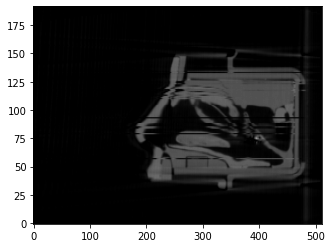

In [8]:
dispNiftiSlice(phantom_img, phantom.header, 'x', 300)

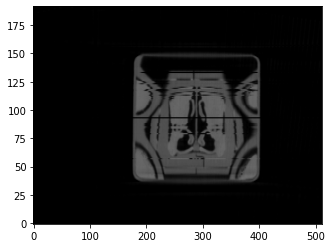

In [9]:
dispNiftiSlice(phantom_img, phantom.header, 'y', 300)

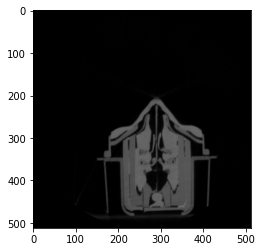

In [10]:
dispNiftiSlice(phantom_img, phantom.header, 'z', 100)

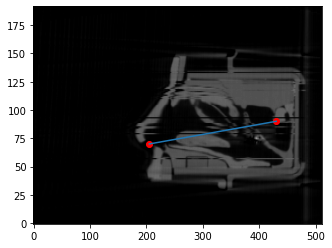

In [11]:


dispNiftiSlice(phantom_img, phantom.header, 'x', 300)

nostrill = [300,205,70]
cancer = [290,430,90]

points = np.array([nostrill, cancer])

plt.scatter(points[:,1],points[:,2],c='r')
plt.plot(points[:,1],points[:,2])


Text(0, 0.5, 'y')

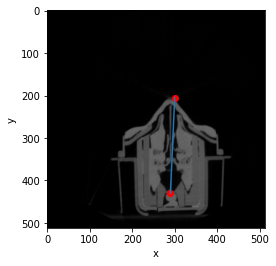

In [12]:
dispNiftiSlice(phantom_img, phantom.header, 'z', 100)
plt.scatter(points[:,0],points[:,1],c='r')
plt.plot(points[:,0],points[:,1])
plt.xlabel('x')
plt.ylabel('y')

# TAKING IMAGES

First we want to rotate it to make it sliceable in the direction of interest

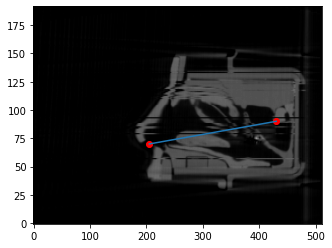

In [13]:
# calculate rotation along x
dispNiftiSlice(phantom_img, phantom.header, 'x', 300)
plt.scatter(points[:,1],points[:,2],c='r')
plt.plot(points[:,1],points[:,2])
plt.show()


In [14]:

z = points[:,2] 
y = points[:,1]
o_a = (z[1]-z[0])/(y[1]-y[0])
print(o_a)
angle_x = math.degrees(math.atan(o_a))
print(angle_x) # angle = (90-70)/(430-205)

0.08888888888888889
5.079607860014571


And now along z

Text(0, 0.5, 'y')

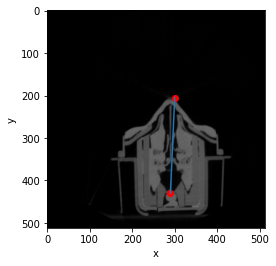

In [15]:
dispNiftiSlice(phantom_img, phantom.header, 'z', 100)
plt.scatter(points[:,0],points[:,1],c='r')
plt.plot(points[:,0],points[:,1])
plt.xlabel('x')
plt.ylabel('y')

In [16]:
x = points[:,0] 
y = points[:,1]
o_a = (x[1]-x[0])/(y[1]-y[0])
print(o_a)
angle_z = math.degrees(math.atan(o_a))
print(angle_z) # angle = (90-70)/(430-205)

-0.044444444444444446
-2.5448043798130957


In [17]:
T = create_transform([0,0,0,angle_x,math.degrees(0),angle_z])
T

array([[ 0.99901381,  0.04440061,  0.        ,  0.        ],
       [-0.04422624,  0.99509032, -0.08853979,  0.        ],
       [-0.00393122,  0.08845247,  0.99607264,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
phantom_img.shape

(512, 512, 192)

from scipy.interpolate import interpn


z = np.arange(0, phantom_img.shape[0])
y = np.arange(0, phantom_img.shape[1])
x = np.arange(0, phantom_img.shape[2])



II, JJ, KK = np.meshgrid(z , y, x, indexing='ij')
image_coordinates =  np.concatenate( (II.reshape(-1,1), JJ.reshape(-1,1), KK.reshape(-1,1), np.ones((np.prod(phantom_img.shape), 1))), axis=1).T


# defining coordinates to sample the gridded data at
xi = np.dot(T, image_coordinates)[:3].T


# specifying the coordinates of the grid
points_i = np.arange(0,phantom_img.shape[0])
points_j = np.arange(0, phantom_img.shape[1])
points_k = np.arange(0, phantom_img.shape[2])
points = (points_i, points_j, points_k)

# performing interpolation and reshaping to the original image shape
image_interpn_flatten = interpn(points, phantom_img, xi, bounds_error=False, fill_value=0)
image_trans = image_interpn_flatten.reshape(phantom_img.shape)



image_trans.shape

# calculate rotation along x
dispNiftiSlice(image_trans, phantom.header, 'x', 300)


dispNiftiSlice(image_trans, phantom.header, 'z', 90)


dispNiftiSlice(image_trans, phantom.header, 'y', 450)



###

Transform = np.array([[0.996761, 0.049510, 0.063369, -122.931002],
                        [0.033279, 0.463408, -0.885520, -132.056007],
                        [-0.073207, 0.884761, 0.460259, -27.597528],
                        [0.000000, 0.000000, 0.000000, 1.000000]])
                        
                        
# defining coordinates to sample the gridded data at
xi = np.dot(Transform, image_coordinates)[:3].T

# performing interpolation and reshaping to the original image shape
image_interpn_flatten_matt = interpn(points, phantom_img, xi, bounds_error=False, fill_value=0)
image_trans_matt = image_interpn_flatten.reshape(phantom_img.shape)
                       
                       
                       
                       
dispNiftiSlice(image_trans_matt, phantom.header, 'y', 450)                       

# VTK SURFACE

dot with 0,0,1

- get rid of anything outside circle
- any values larger than 5cm away
- any normals facing away (dot product with 0,0,1) 
- 2.5cm either side

In [19]:
# load points and normals


filename = '3D_images/new_surface_consistent_normals.vtk'
model = VTKSurfaceModel(filename, (1.0, 1.0, 1.0), opacity=1.0)
points = model.get_points_as_numpy()
normals = model.get_normals_as_numpy()

In [20]:
print(points.shape, normals.shape)

(237319, 3) (237319, 3)


In [21]:
print(points,normals)

[[  44.125   183.873  -148.357 ]
 [  43.9406  183.592  -148.171 ]
 [  43.9447  183.948  -148.186 ]
 ...
 [ 149.      112.      -46.1029]
 [ 170.045   168.339   -41.0706]
 [ 170.031   168.295   -41.0524]] [[-0.6928378  -0.02239369 -0.72074574]
 [-0.5255059   0.04258029 -0.8497238 ]
 [-0.58957195 -0.027227   -0.8072569 ]
 ...
 [ 0.          0.          0.        ]
 [-0.5566408  -0.16014394 -0.8151717 ]
 [-0.5566408  -0.16014394 -0.8151717 ]]


In [22]:
# transform to get from model to camera coords
T_model_cam = np.array([[0.996761, 0.049510, 0.063369, -122.931002],
                        [0.033279, 0.463408, -0.885520, -132.056007],
                        [-0.073207, 0.884761, 0.460259, -27.597528],
                        [0.000000, 0.000000, 0.000000, 1.000000]])

In [23]:
def make_homogenous(matrix_NX3):
    matrix_NX4 = np.ones((matrix_NX3.shape[0],4))
    
    matrix_NX4[:,:3] = matrix_NX3
    return matrix_NX4

In [24]:
# making points homogenous coordinates
points_hom = make_homogenous(points)


In [25]:
points_hom

array([[  44.125     ,  183.8730011 , -148.35699463,    1.        ],
       [  43.94060135,  183.59199524, -148.17100525,    1.        ],
       [  43.94469833,  183.94799805, -148.18600464,    1.        ],
       ...,
       [ 149.        ,  112.        ,  -46.10290146,    1.        ],
       [ 170.04499817,  168.33900452,  -41.0705986 ,    1.        ],
       [ 170.03100586,  168.29499817,  -41.05239868,    1.        ]])

In [26]:
# converting points to camera coords

points_cam = multiply_points_by_matrix(T_model_cam, points_hom, do_transpose='False')
points_cam

array([[-79.24660498,  85.99373445,  63.57323146,   1.        ],
       [-79.43253301,  85.69268017,  63.42371099,   1.        ],
       [-79.41177409,  85.87107332,  63.73148486,   1.        ],
       ...,
       [ 28.21001224, -34.3706987 ,  39.36858568,   1.        ],
       [ 52.29508177, -12.01860163,  89.99066115,   1.        ],
       [ 52.28010934, -12.05557656,  89.96112706,   1.        ]])

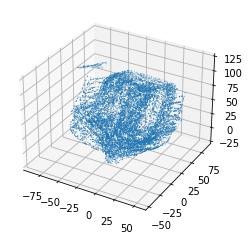

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points_cam[::20,0], points_cam[::20,1], points_cam[::20,2], marker='*', s=0.000001)

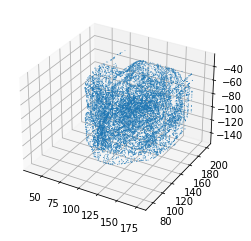

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[::20,0], points[::20,1], points[::20,2], marker='*', s=0.000001)

### get rid of any points where normals facing away

In [29]:
T_rot = T_model_cam[:3,:3]

# convert normals to cam coords
normals_cam = normals @ T_rot

# normal representing the direction of the camera
cam_norm = np.array([0,0,1])

# dot product to check they are facing the same direction or not
dot_prod = np.degrees(np.dot(normals_cam, cam_norm))
print('min', np.min(dot_prod))
print('max', np.max(dot_prod))

# taking only those facing the opoposite direction as camera
same_dir_idx = np.where(dot_prod<0)
print(same_dir_idx)

min -57.29133522054197
max 57.295451481200686
(array([     0,      1,      2, ..., 237312, 237317, 237318]),)


In [30]:
points_cam_norm_filtered = points_cam[same_dir_idx]

### TAKE ANYTHING WITHIN 5CM only

In [31]:
print('min', np.min(points_cam[:,0]),np.min(points_cam_norm_filtered[:,1]),np.min(points_cam_norm_filtered[:,2]))
print('max', np.max(points_cam[:,0]),np.max(points_cam_norm_filtered[:,1]),np.max(points_cam_norm_filtered[:,2]))


min -88.06348343818283 -44.122348264411926 -18.4323180025711
max 54.725597448486326 88.30576300175096 118.97643075348283


min -19.999529310955054 -24.991834538696295 20.003503411056524
max 19.994617767570503 24.99862083742522 79.98592179229738


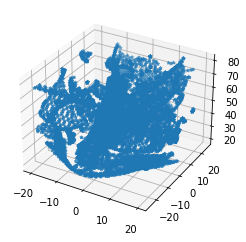

In [32]:

# in z
filtered_points = points_cam_norm_filtered[points_cam_norm_filtered[:,2]<80] # back
filtered_points = filtered_points[filtered_points[:,2]>20] # front

# in x
filtered_points = filtered_points[filtered_points[:,0]<=20] # left
filtered_points = filtered_points[filtered_points[:,0]>=-20] # right

# in y 
filtered_points = filtered_points[filtered_points[:,1]<=25] # bottom
filtered_points = filtered_points[filtered_points[:,1]>-25] # top

print('min', np.min(filtered_points[:,0]),np.min(filtered_points[:,1]),np.min(filtered_points[:,2]))
print('max', np.max(filtered_points[:,0]),np.max(filtered_points[:,1]),np.max(filtered_points[:,2]))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(filtered_points[::2,0], filtered_points[::2,1], filtered_points[::2,2], marker='*', s=10)

In [33]:
np.savetxt('points_cam.txt',points_cam[:,:3])
np.savetxt('filtered_points.txt',filtered_points[:,:3])

In [34]:
filtered_points

array([[ -6.90080267,  24.42196027,  25.48275243,   1.        ],
       [ -9.38022016,  21.27689625,  21.31575404,   1.        ],
       [ -9.10140018,  21.34897506,  21.47036309,   1.        ],
       ...,
       [-18.54916517,  -1.46868902,  24.64593952,   1.        ],
       [ -1.23278233,  -0.31204245,  76.35896984,   1.        ],
       [ 16.52690248, -11.0654159 ,  56.44730034,   1.        ]])

In [35]:
points_cam.shape

(237319, 4)

### project points from 3D to 2D

In [36]:
intrinsics = np.loadtxt('/Users/aure/Desktop/i4health/project/endoSim/endosim/calibrations/endoscope_calibration_3_0zoom/endoscope.intrinsics.txt')
distortion = np.loadtxt('/Users/aure/Desktop/i4health/project/endoSim/endosim/calibrations/endoscope_calibration_3_0zoom/endoscope.distortion.txt')


In [37]:
intrinsics

array([[664.6329766 ,   0.        , 931.53151205],
       [  0.        , 663.83211807, 520.64004697],
       [  0.        ,   0.        ,   1.        ]])

In [38]:
distortion

array([-4.0929449e-01,  2.1631278e-01,  1.1120000e-05,  1.2712000e-03,
       -7.2057120e-02])

In [39]:
type(filtered_points[0,0])

numpy.float64

In [40]:
print(points_cam[0].dtype)
print(filtered_points[0].dtype)

print(points_cam.shape)
print(filtered_points.shape)

print(points_cam[:,:4])
print(filtered_points[:,:4])

float64
float64
(237319, 4)
(18936, 4)
[[-79.24660498  85.99373445  63.57323146   1.        ]
 [-79.43253301  85.69268017  63.42371099   1.        ]
 [-79.41177409  85.87107332  63.73148486   1.        ]
 ...
 [ 28.21001224 -34.3706987   39.36858568   1.        ]
 [ 52.29508177 -12.01860163  89.99066115   1.        ]
 [ 52.28010934 -12.05557656  89.96112706   1.        ]]
[[ -6.90080267  24.42196027  25.48275243   1.        ]
 [ -9.38022016  21.27689625  21.31575404   1.        ]
 [ -9.10140018  21.34897506  21.47036309   1.        ]
 ...
 [-18.54916517  -1.46868902  24.64593952   1.        ]
 [ -1.23278233  -0.31204245  76.35896984   1.        ]
 [ 16.52690248 -11.0654159   56.44730034   1.        ]]


In [41]:
rvec = np.zeros((1,3))
tvec = np.zeros((1,3))

points2D, jacobian = cv2.projectPoints(np.array(filtered_points[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)


In [42]:
points2D = np.squeeze(points2D)
points2D

array([[ 799.92369965,  988.80854663],
       [ 728.75719182,  982.31985749],
       [ 734.99340147,  983.42154853],
       ...,
       [ 520.97062201,  488.13787888],
       [ 920.80319553,  517.92770538],
       [1117.10852888,  396.60966273]])

In [43]:
#from endosimutilities.end_utils import project_camera_points_to_image

#points2D = np.squeeze(project_camera_points_to_image(points_cam[:,:3], intrinsics, distortion))

In [44]:
print('mean', np.mean(points2D[:,0]))
print('min', np.min(points2D[:,0]))
print('max', np.max(points2D[:,0]))


mean 926.3217567954688
min 458.07690005240346
max 1406.4792379416026


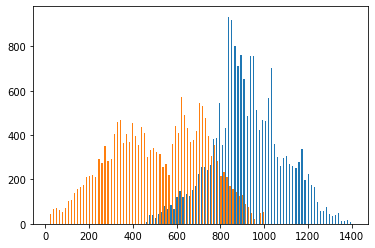

In [45]:
plt.hist(points2D[points2D[:,0]>0], bins=100)
plt.show()

In [46]:
points2D[points2D[:,0]>0].shape

(18936, 2)

In [47]:
filtered_points2D = points2D[points2D[:,0]>0]
filtered_points2D = filtered_points2D[filtered_points2D[:,1]>0]

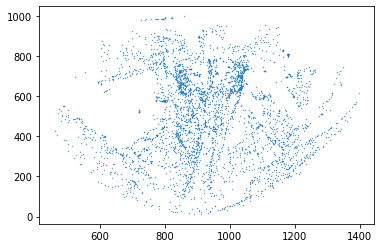

In [48]:
fig, ax = plt.subplots()
ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)

### take only things inside the circle

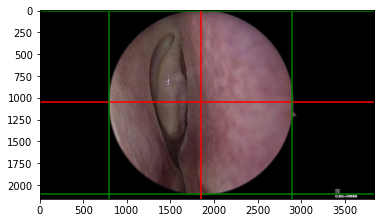

In [49]:

endoscope_image = 'images/00000010.jpg'
image = Image.open(endoscope_image)
image = np.array(image)


image_shape = image.shape

plt.imshow(image)


# finding mid y position
low_y = 0
high_y = 2100
plt.axhline(y=low_y, color='g', linestyle='-')
plt.axhline(y=high_y, color='g', linestyle='-')

mid_y = (high_y-low_y)/2
plt.axhline(y=mid_y, color='r', linestyle='-')

low_x = 800
high_x = 2900
plt.axvline(x=low_x, color='g', linestyle='-')
plt.axvline(x=high_x, color='g', linestyle='-')

mid_x = (high_x-low_x)/2 +low_x
plt.axvline(x=mid_x, color='r', linestyle='-')

centre = [mid_x,mid_y]
radius = mid_x-low_x # could also be mid_y-low_y, or negative of mid_x-high_x or -ve of mid_y-high_y

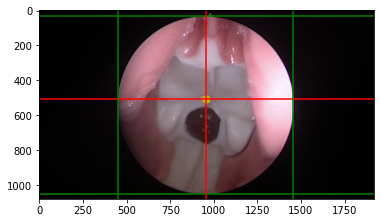

In [50]:
# STORZ ENDOSCOPE!

endoscope_image = 'images/00000398.jpg'
image = Image.open(endoscope_image)
image = np.array(image)


image_shape = image.shape

plt.imshow(image)


# finding mid y position
low_y = 30
high_y = 1050
plt.axhline(y=low_y, color='g', linestyle='-')
plt.axhline(y=high_y, color='g', linestyle='-')

mid_y = (high_y-low_y)/2
plt.axhline(y=mid_y, color='r', linestyle='-')

low_x = 450
high_x = 1455
plt.axvline(x=low_x, color='g', linestyle='-')
plt.axvline(x=high_x, color='g', linestyle='-')

mid_x = (high_x-low_x)/2 +low_x
plt.axvline(x=mid_x, color='r', linestyle='-')

centre = [mid_x,mid_y]
plt.scatter(mid_x,mid_y, color='y', s=50)

radius = mid_x-low_x # could also be mid_y-low_y, or negative of mid_x-high_x or -ve of mid_y-high_y

In [51]:
# distance from centre - (x2-x1)**2-(y2-y1)*2
# instead of squarerooting here to get distance correctly I just squared the radius instead
d = (filtered_points2D[:,0]-mid_x)**2 + (filtered_points2D[:,1]-mid_y)**2
res = d < radius**2

In [52]:
# lying within radius
res

array([False, False, False, ...,  True,  True,  True])

In [53]:
filtered_points2D_within_end = filtered_points2D[res]
filtered_points2D_within_end

array([[ 867.33782571, 1000.20456151],
       [ 796.73796792,  987.51111127],
       [ 815.85524691,  990.6181098 ],
       ...,
       [ 520.97062201,  488.13787888],
       [ 920.80319553,  517.92770538],
       [1117.10852888,  396.60966273]])

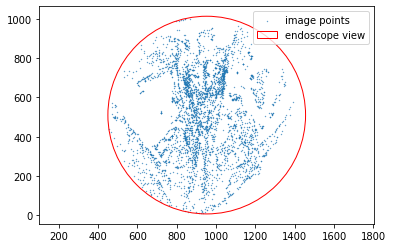

In [54]:
fig, ax = plt.subplots()

ax.scatter(filtered_points2D_within_end[::5,0], filtered_points2D_within_end[::5,1], s=0.1)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

ax.add_patch(circle)
ax.axis('equal')
plt.legend(['image points', 'endoscope view'])


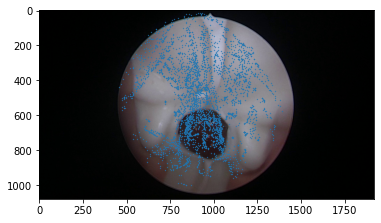

In [55]:
endoscope_image = 'images/00000366.jpg'
image = Image.open(endoscope_image)
image = np.array(image)


image_shape = image.shape

plt.imshow(image)
plt.scatter(filtered_points2D_within_end[::5,0].T, filtered_points2D_within_end[::5,1].T, s=0.1)

In [56]:
circle = plt.Circle((0, 0), 0.2, color='r')

ax.add_patch(circle)


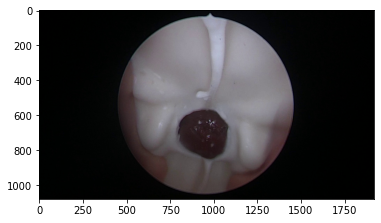

In [57]:

endoscope_image = 'images/00000366.jpg'
image = Image.open(endoscope_image)
image = np.array(image)


image_shape = image.shape

plt.imshow(image)

# CANCER SURFACE

In [58]:


cancer_filename = '3D_images/cancer.vtk'
cancer_model = VTKSurfaceModel(cancer_filename, (1.0, 1.0, 1.0), opacity=1.0)
cancer_points = cancer_model.get_points_as_numpy()
cancer_normals = cancer_model.get_normals_as_numpy()

In [59]:
# converting points to camera coords
cancer_points_hom = make_homogenous(cancer_points)

cancer_points_cam = multiply_points_by_matrix(T_model_cam, cancer_points_hom, do_transpose='False')
print(cancer_points_cam)


[[-1.26266494 29.62062576 81.19922063  1.        ]
 [-1.24656997 29.15541074 81.2068831   1.        ]
 [-1.44359797 29.24488118 81.40614737  1.        ]
 ...
 [ 4.04720943 21.03363692 92.90451218  1.        ]
 [ 2.41313644 21.17070512 93.39320538  1.        ]
 [ 2.43368352 21.3630234  93.76038876  1.        ]]


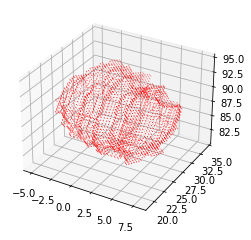

In [60]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cancer_points_cam[::1,0], cancer_points_cam[::1,1], cancer_points_cam[::1,2], c='r', marker='*', s=0.000001)


In [61]:
cancer_points2D, jacobian = cv2.projectPoints(np.array(cancer_points_cam[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
cancer_points2D = np.squeeze(cancer_points2D)



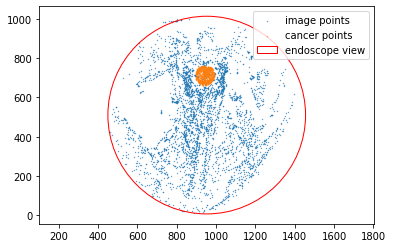

In [62]:
fig, ax = plt.subplots()
ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

ax.add_patch(circle)
ax.axis('equal')
plt.legend(['image points','cancer points', 'endoscope view'])

### ADDING NOISE TO CANCER


In [63]:
# ADDING NOISE TO CANCER POINTS
cancer_points_noisy = add_noise_to_points(cancer_points,0.7)
# converting points to camera coords
cancer_points_hom_noisy = make_homogenous(cancer_points_noisy)

cancer_points_cam_noisy = multiply_points_by_matrix(T_model_cam, cancer_points_hom_noisy, do_transpose='False')
print(cancer_points_cam_noisy)



[[-2.05709031 28.75799955 82.20708648  1.        ]
 [-2.04482565 29.94734586 81.5251311   1.        ]
 [-1.76314486 29.23733887 80.17650724  1.        ]
 ...
 [ 4.01863196 21.24189775 92.99384454  1.        ]
 [ 1.73751504 21.29096665 92.39598429  1.        ]
 [ 2.60441797 22.64885745 93.99751813  1.        ]]


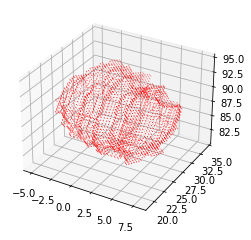

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cancer_points_cam[::1,0], cancer_points_cam[::1,1], cancer_points_cam[::1,2], c='r', marker='*', s=0.000001)


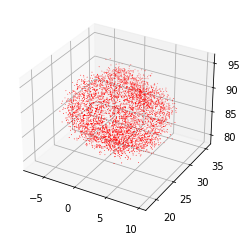

In [65]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cancer_points_cam_noisy[::1,0], cancer_points_cam_noisy[::1,1], cancer_points_cam_noisy[::1,2], c='r', marker='*', s=0.000001)


In [66]:
cancer_points2D_noisy, jacobian = cv2.projectPoints(np.array(cancer_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
cancer_points2D_noisy = np.squeeze(cancer_points2D_noisy)



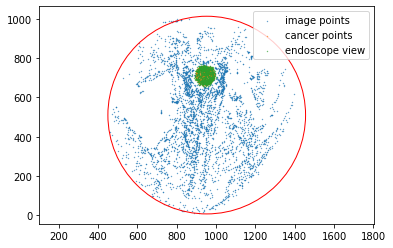

In [67]:
fig, ax = plt.subplots()
ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D_noisy[::5,0], cancer_points2D_noisy[::5,1], s=0.1)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

ax.add_patch(circle)
ax.axis('equal')
plt.legend(['image points','cancer points', 'endoscope view'])

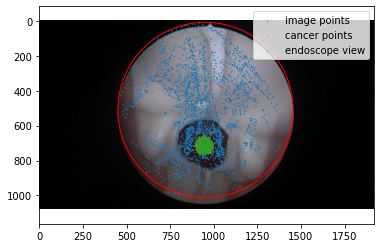

In [68]:
endoscope_image = 'images/00000366.jpg'
image = Image.open(endoscope_image)
image = np.array(image)




fig, ax = plt.subplots()
ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D_noisy[::5,0], cancer_points2D_noisy[::5,1], s=0.1)
ax.imshow(image)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

ax.add_patch(circle)
ax.axis('equal')
plt.legend(['image points','cancer points', 'endoscope view'])


image_shape = image.shape



# ADDING NOISE TO TRANSFORM

[[-1.76382554 29.44028376 82.31234333  1.        ]
 [-1.74710527 28.97506898 82.31853978  1.        ]
 [-1.94493766 29.0636126  82.51742091  1.        ]
 ...
 [ 3.51807543 20.82239676 94.00758191  1.        ]
 [ 1.88215251 20.95559346 94.49113243  1.        ]
 [ 1.90117641 21.14673667 94.85901075  1.        ]]
error in sigma 0.12: [41.76225749 49.31535963]


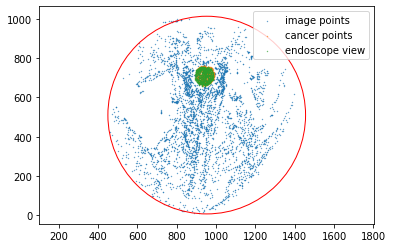

In [69]:
sigma = 0.12


T_parameters = extract_rigid_body_parameters(T_model_cam)

T_parameters_noisy = add_noise_to_params(T_parameters, sigma)
T_model_cam_noisy = rigid_body_parameters_to_matrix(T_parameters_noisy)



# transforming cancer with noisy transform

# converting points to camera coords
# cancer_points_hom_noisy = make_homogenous(cancer_points_noisy)

cancer_points_cam_noisy = multiply_points_by_matrix(T_model_cam_noisy, cancer_points_hom, do_transpose='False')
print(cancer_points_cam_noisy)



# project cancer

cancer_points2D_noisy, jacobian = cv2.projectPoints(np.array(cancer_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
cancer_points2D_noisy = np.squeeze(cancer_points2D_noisy)

euclid_dist =  calculate_euclid_dist(cancer_points2D, cancer_points2D_noisy)
print(f'error in sigma {sigma}: {euclid_dist}')

# PLOT
fig, ax = plt.subplots()
ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)
ax.scatter(cancer_points2D_noisy[::5,0], cancer_points2D_noisy[::5,1], s=0.1)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

ax.add_patch(circle)
ax.axis('equal')
plt.legend(['image points','cancer points', 'endoscope view'])

In [70]:
cancer_points2D

array([[921.8352528 , 750.46879165],
       [921.94248122, 747.1925867 ],
       [920.43839154, 747.30994437],
       ...,
       [959.92072281, 667.77029973],
       [948.39381428, 668.01159857],
       [948.46747623, 668.7366885 ]])

error in sigma 0.12: 4.384338650239478
error in sigma 0.25: 9.15207075788859


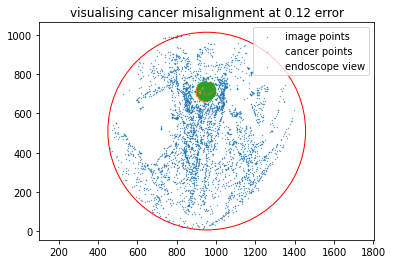

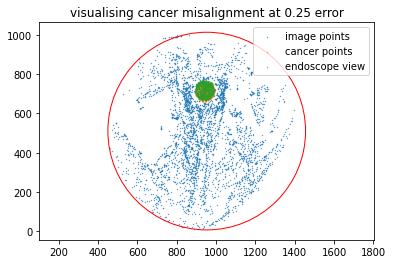

In [71]:



number_samples = 10000
x_values = []
y_values = []
#for sigma_counter in range(0, 100, 1):
for sigma_counter in [0.12, 0.25]:
    #sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # adding noise to transform parameters
        T_parameters_noisy = add_noise_to_params(T_parameters, sigma_counter)
        T_model_cam_noisy = rigid_body_parameters_to_matrix(T_parameters_noisy)

        # transforming cancer with noisy transform
        cancer_points_cam_noisy = multiply_points_by_matrix(T_model_cam_noisy, cancer_points_hom, do_transpose='False')

        # project cancer
        cancer_points2D_noisy, jacobian = cv2.projectPoints(np.array(cancer_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
        cancer_points2D_noisy = np.squeeze(cancer_points2D_noisy)

        # calculate euclidean distance
        #euclid_dist =  calculate_euclid_dist(cancer_points2D, cancer_points2D_noisy)
        
        # average of euclidean distance of all points in the cancer
        distances = []

        for idx, cancer in enumerate(cancer_points2D):
            cancer_noisy = cancer_points2D_noisy[idx]

            dist =  (cancer[0] - cancer_noisy[0]) \
                             * (cancer[0] - cancer_noisy[0]) \
                             + (cancer[1] - cancer_noisy[1]) \
                             * (cancer[1] - cancer_noisy[1]) 

            distances.append(dist)

        euclid_dist = mean(distances)
        
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    #if sigma == 0.25:
    #rms_25 = rms
    print(f'error in sigma {sigma_counter}: {rms}')
    
    # PLOT
    fig, ax = plt.subplots()
    ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
    ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)
    ax.scatter(cancer_points2D_noisy[::5,0], cancer_points2D_noisy[::5,1], s=0.1)
    ax.set_title(f'visualising cancer misalignment at {sigma_counter} error')
    circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

    ax.add_patch(circle)
    ax.axis('equal')
    plt.legend(['image points','cancer points', 'endoscope view'])

    x_values.append(sigma)
    y_values.append(rms)
    
#plt.plot(x_values, y_values, 'r', label='TRE (mm)')
#plt.legend(loc='upper left')
#plt.xlabel('sigma (rotations(degrees)/translations(mm))')
#plt.ylabel('TRE (mm)')
#plt.show()
     

In [72]:
#from statistics import mean 

#distances = []

#for idx, cancer in enumerate(cancer_points2D):
#    cancer_noisy = cancer_points2D_noisy[idx]
    
#    euclid_dist =  (cancer[0] - cancer_noisy[0]) \
#                     * (cancer[0] - cancer_noisy[0]) \
#                     + (cancer[1] - cancer_noisy[1]) \
#                     * (cancer[1] - cancer_noisy[1]) 
#    
#    distances.append(euclid_dist)
    
#print(mean(distances))   

error in sigma 0.12: 4.431232149551488
error in sigma 0.25: 9.102220533936634
error in sigma 0.5: 18.315583806655905
error in sigma 0.75: 27.487745650680846


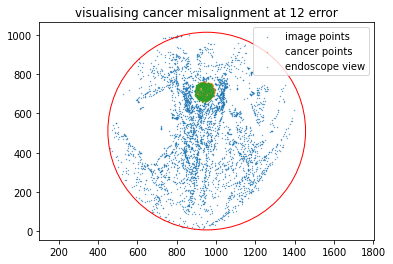

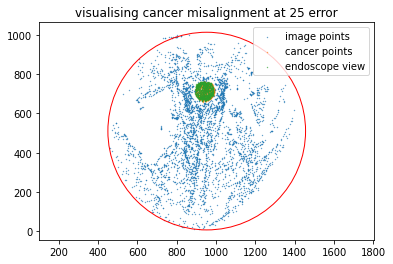

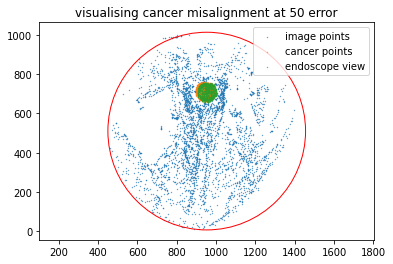

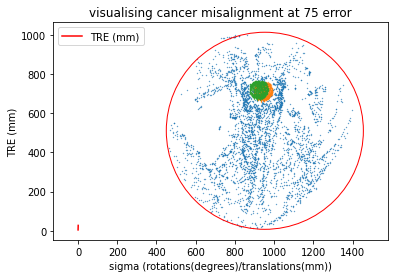

In [73]:


number_samples = 10000
x_values = []
y_values = []
for sigma_counter in range(0, 100, 1):
#for sigma_counter in [0.12, 0.25]:
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # adding noise to transform parameters
        T_parameters_noisy = add_noise_to_params(T_parameters, sigma)
        T_model_cam_noisy = rigid_body_parameters_to_matrix(T_parameters_noisy)

        # transforming cancer with noisy transform
        cancer_points_cam_noisy = multiply_points_by_matrix(T_model_cam_noisy, cancer_points_hom, do_transpose='False')

        # project cancer
        cancer_points2D_noisy, jacobian = cv2.projectPoints(np.array(cancer_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
        cancer_points2D_noisy = np.squeeze(cancer_points2D_noisy)

        # calculate euclidean distance
        #euclid_dist =  calculate_euclid_dist(cancer_points2D, cancer_points2D_noisy)
        
        # average of euclidean distance of all points in the cancer
        distances = []

        for idx, cancer in enumerate(cancer_points2D):
            cancer_noisy = cancer_points2D_noisy[idx]

            dist =  (cancer[0] - cancer_noisy[0]) \
                             * (cancer[0] - cancer_noisy[0]) \
                             + (cancer[1] - cancer_noisy[1]) \
                             * (cancer[1] - cancer_noisy[1]) 

            distances.append(dist)

        euclid_dist = mean(distances)
        
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25 or sigma == 0.12 or sigma == 0.5  or sigma == 0.75 or sigma == 1:
    #rms_25 = rms
        print(f'error in sigma {sigma}: {rms}')

        # PLOT
        fig, ax = plt.subplots()
        ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
        ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)
        ax.scatter(cancer_points2D_noisy[::5,0], cancer_points2D_noisy[::5,1], s=0.1)
        ax.set_title(f'visualising cancer misalignment at {sigma_counter} error')
        circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

        ax.add_patch(circle)
        ax.axis('equal')
        plt.legend(['image points','true tumour points', 'noisy tumour points' 'endoscope view'])

        x_values.append(sigma)
        y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

error in sigma 0.12: 4.4583655442879
error in sigma 0.25: 8.971357212194812
error in sigma 0.5: 17.700741729601972
error in sigma 0.75: 27.153002919609634


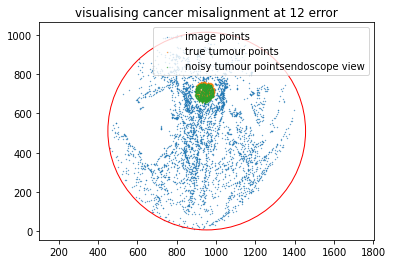

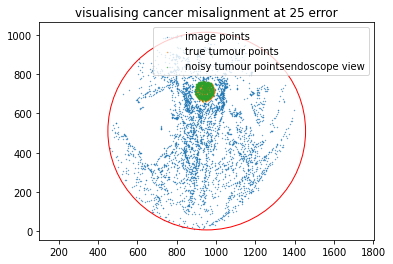

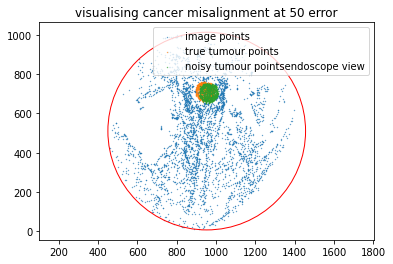

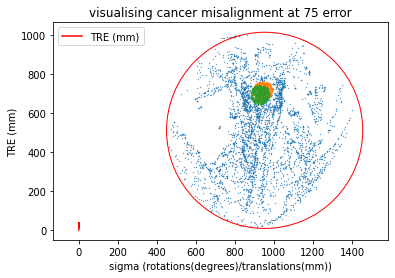

In [84]:

number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 100, 1):
#for sigma_counter in [0.12, 0.25]:
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # adding noise to transform parameters
        T_parameters_noisy = add_noise_to_params(T_parameters, sigma)
        T_model_cam_noisy = rigid_body_parameters_to_matrix(T_parameters_noisy)

        # transforming cancer with noisy transform
        cancer_points_cam_noisy = multiply_points_by_matrix(T_model_cam_noisy, cancer_points_hom, do_transpose='False')

        # project cancer
        cancer_points2D_noisy, jacobian = cv2.projectPoints(np.array(cancer_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
        cancer_points2D_noisy = np.squeeze(cancer_points2D_noisy)

        # calculate euclidean distance
        #euclid_dist =  calculate_euclid_dist(cancer_points2D, cancer_points2D_noisy)
        
        # average of euclidean distance of all points in the cancer
        distances = []

        for idx, cancer in enumerate(cancer_points2D):
            cancer_noisy = cancer_points2D_noisy[idx]

            dist =  (cancer[0] - cancer_noisy[0]) \
                             * (cancer[0] - cancer_noisy[0]) \
                             + (cancer[1] - cancer_noisy[1]) \
                             * (cancer[1] - cancer_noisy[1]) 

            distances.append(dist)

        euclid_dist = mean(distances)
        
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25 or sigma == 0.12 or sigma == 0.5  or sigma == 0.75 or sigma == 1:
    #rms_25 = rms
        print(f'error in sigma {sigma}: {rms}')

        # PLOT
        fig, ax = plt.subplots()
        ax.scatter(filtered_points2D[::5,0], filtered_points2D[::5,1], s=0.1)
        ax.scatter(cancer_points2D[::5,0], cancer_points2D[::5,1], s=0.1)
        ax.scatter(cancer_points2D_noisy[::5,0], cancer_points2D_noisy[::5,1], s=0.1)
        ax.set_title(f'visualising cancer misalignment at {sigma_counter} error')
        circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

        ax.add_patch(circle)
        ax.axis('equal')
        plt.legend(['image points','true tumour points', 'noisy tumour points' 'endoscope view'])

    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

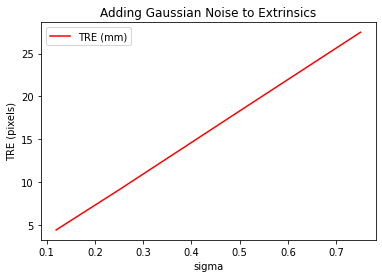

In [83]:
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.title('Adding Gaussian Noise to Extrinsics')

plt.xlabel('sigma')
plt.ylabel('TRE (pixels)')
plt.show()